#Домашнее задание: реализация модели latent diffusion

### Дополнительное задание [дополнительный 1 балл]. Модификации conditional guidance*
*Дополнительный балл не умножается на коэффициент домашнего задания*

---

Далее, вам предлагается реализовать conditional guidance на этом датасете. Как уже упоминалось на лекции механизм conditional guidance позволяет вам генерировать изображения с выбранными вами условиями (картинки определенных цветков, например). На семинаре 2 был показан участок кода, который реализовал условную генерацию, однако для этого вам нужно добавить прокидывание условия в UNet и чуть поменять процесс условной генерации. При реализации вы можете опираться адаптировать следующую [реализацию](https://github.com/TeaPearce/Conditional_Diffusion_MNIST).

**Ожидаемый результат**

В качестве результатов модели, от вас требуется предоставить визуализации генераций, полученных от вашей модели, и код обучения модели.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!pip install diffusers[training] -q

!pip install accelerate -q
!pip install -qq diffusers==0.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 12.3 MB/s eta 0:00:00


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
BASE_PATH = '/content/drive/Othercomputers/My_comp/Documents/МФТИ - Наука о данных/Современные модели DL/Latent/'

In [154]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 64 # сгенерированное разрешение изображения
    train_batch_size = 16
    eval_batch_size = 16  # сколько изображений мы можем сэмплировать во время eval
    num_epochs = 30
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 1
    mixed_precision = 'fp16'  # `no` для float32, `fp16` для автоматической смешанной точности
    output_dir = BASE_PATH + 'flowers-128-cond'  # имя модели локально и на HF Hub
    push_to_hub = False  # Если True, то загружаем сохраненную модель в HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # Если True, то перезаписываем старую модель при повторном запуске ноутбука
    seed = 0

config = TrainingConfig()

## Загрузка набора данных

Мы будем использовать библиотеку [🤗 Datasets](https://github.com/huggingface/datasets) для загрузки нашего набора данных изображений.

В этом случае [набор данных Butterflies](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset) размещается удаленно, но вы можете загрузить локальную папку [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder), как показано в комментариях ниже.

In [7]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00


In [109]:
from datasets import load_dataset

# Можно загрузить другие датасеты из https://hf.co/huggan/
# Например датасет с фотографиями цветков:
config.dataset_name = "nelorth/oxford-flowers" #"BirdL/DALL-E-Dogs" #
dataset = load_dataset(config.dataset_name, split="train")

# Или можете загрузить свой датасет
# config.dataset_name = name
# dataset = load_dataset(config.dataset_name, data_dir=path)

Набор данных содержит разные признаки, но нас интересует `image`:

In [75]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 7169
})

In [110]:
dataset = dataset.rename_column('image', "images")
dataset

Dataset({
    features: ['images', 'label'],
    num_rows: 7169
})

In [111]:
dataset = dataset.filter(lambda x: x['label'] in np.arange(50))

In [112]:
dataset

Dataset({
    features: ['images', 'label'],
    num_rows: 2930
})

In [13]:
import gc
gc.collect()

48

In [155]:
import io
def plot_listimages(set_imgs, sel_labls, figsize=(10, 10), save = False):
    a = round(np.sqrt(len(set_imgs)))
    if a != np.sqrt(len(set_imgs)):
        b = b = int(12/a)
    else: b = a
    # и соответствующие сегментации
    plt.figure(figsize=figsize)

    for i, (img, lbl) in enumerate(zip(set_imgs, sel_labls)):
        plt.subplot(a, b, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"class:{lbl}")
    plt.tight_layout()
    #plt.show()

    if save:
      buf = io.BytesIO()
      plt.savefig(buf, format='png')
      buf.seek(0)
      im = Image.open(buf).convert("RGB")

      buf.close()

      return im



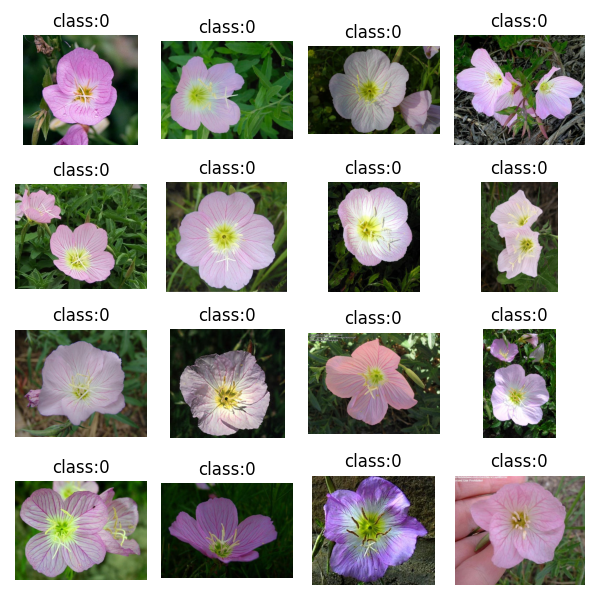

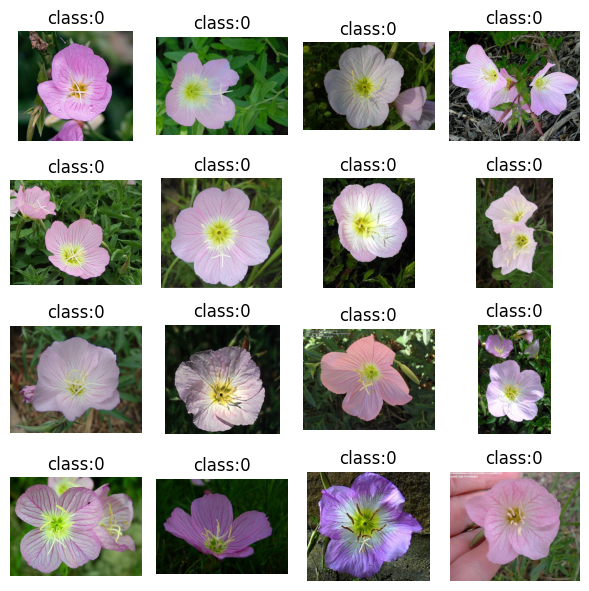

In [127]:
plot_listimages(dataset[:16]['images'],dataset[:16]['label'], save = True)


# Preprocess data

Поскольку [`Image`](https://huggingface.co/docs/datasets/image_process#image-datasets) загружает изображения с помощью PIL, мы можем легко рассмотреть несколько примеров:

Все изображения в наборе данных разные, поэтому нам нужно сначала их предварительно обработать:
* `Resize` приводит изображения в соответствие с квадратным разрешением `config.image_size`.
* `RandomHorizontalFlip` дополняет набор данных, случайным образом зеркалируя изображения.
* `Normalize` важен для изменения масштаба значений пикселей в диапазон `[-1, 1]` (чего и ожидает наша модель).

In [80]:
ALL_LABELS = set(dataset["label"])
NUM_CLASSES = len(ALL_LABELS)

In [81]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),

        #transforms.RandomVerticalFlip(p = 0.25),
        #transforms.RandomRotation((0,8)),
        transforms.CenterCrop(config.image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees = 2),
        transforms.ColorJitter(),
        transforms.RandomInvert(),
        transforms.RandomAutocontrast(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


🤗 Наборы данных предлагают удобный метод set_transform() для применения преобразований изображений «на лету» во время обучения:

In [130]:
def transforms(examples):
    examples["images"] = [
        preprocess(image) for image in examples["images"]
    ]
    #examples["label"] = [
     #   str(l) for l in examples["label"]
    #]
    return examples


dataset.set_transform(transforms)

Давайте посмотрим, как они выглядят сейчас

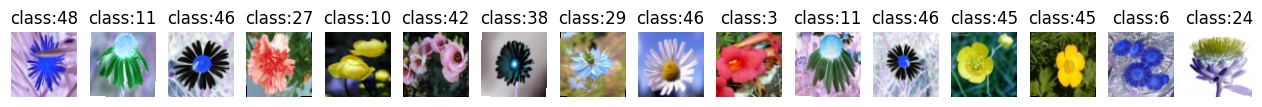

In [131]:
q_ty = config.eval_batch_size

small_dataset = dataset.select(np.random.randint(1, len(dataset), q_ty))
fig, axs = plt.subplots(1, q_ty, figsize=(16, 4))
for i in range(q_ty):
  axs[i].imshow(small_dataset[i]['images'].permute(1, 2, 0).numpy() / 2 + 0.5)
  axs[i].set_axis_off()
  axs[i].set_title(f"class:{small_dataset[i]['label']}")
fig.show();

#Cond_model

## Creating a Class-Conditioned UNet

The way we'll feed in the class conditioning is as follows:
- Create a standard `UNet2DModel` with some additional input channels  
- Map the class label to a learned vector of shape `(class_emb_size)`via an embedding layer
- Concatenate this information as extra channels for the internal unet input with `net_input = torch.cat((x, class_cond), 1)`
- Feed this `net_input` (which has (`class_emb_size+1`) channels in total) into the unet to get the final prediction

In this example I've set the class_emb_size to 4, but this is completely arbitrary and you could explore having it size 1 (to see if it still works), size 10 (to match the number of classes), or replacing the learned nn.Embedding with a simple one-hot encoding of the class label directly.

This is what the implementation looks like:

In [84]:
import torch
from torch import nn
from diffusers import UNet2DModel

class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=NUM_CLASSES, class_emb_size=16):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)
    #self.device = torch.device('cpu') # device parameter not defined by default for modules
    #self.dummy_param = nn.Parameter(torch.empty(0))


    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
    sample_size = config.image_size,    # разрешение таргетного изображения
    in_channels =  3 + class_emb_size,  # количество входных каналов, 3 для RGB изображений
    out_channels = 3 ,                 # количество выходных каналов
    layers_per_block=2,  # сколько ResNet слоев использовать для каждого UNet блока
    block_out_channels=(32, 32, 64, 64, 64),  # количество выходных каналов для каждого UNet блока
    down_block_types=(
        "DownBlock2D",  # обычный ResNet блок понижения дискретизации
        "AttnDownBlock2D",  # ResNet блок понижения дискретизации с самовниманием
        #"DownBlock2D",
        #"AttnDownBlock2D",  # ResNet блок понижения дискретизации с самовниманием
        "DownBlock2D",
        "AttnDownBlock2D",  # ResNet блок понижения дискретизации с самовниманием
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",      # обычный ResNet блок повышения дискретизации
        "AttnUpBlock2D",  # a ResNet блок повышения дискретизации с самовниманием
        "UpBlock2D",
        #"AttnUpBlock2D",  # a ResNet блок повышения дискретизации с самовниманием
        #"UpBlock2D",
       "AttnUpBlock2D",  # a ResNet блок повышения дискретизации с самовниманием
        "UpBlock2D"
      ),
)

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    #self.device = self.dummy_param.device
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dinemsion
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the unet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

    #def _apply(self, fn):
        # https://stackoverflow.com/questions/54706146/moving-member-tensors-with-module-to-in-pytorch
        # override apply by moving the attribute device of the class object as well.
        # This allows to directly know where the class is when creating new attribute for the class object.
        #super()._apply(fn)
        ##self.device = fn(self.device)
       # return self

    @property
    def device(self):
        return next(self.parameters()).device
    return self

In [85]:
cond_model = ClassConditionedUnet()
cond_model

ClassConditionedUnet(
  (class_emb): Embedding(50, 16)
  (model): UNet2DModel(
    (conv_in): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=32, out_features=128, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )


# Dataloader

Теперь, когда все наши изображения имеют одинаковый размер и преобразованы в тензоры, мы можем создать dataloader, который будем использовать для обучения.

In [132]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [133]:
dataiter = iter(train_dataloader)
sample_batch = next(dataiter)
sample_batch['images'].shape

torch.Size([16, 3, 64, 64])

In [134]:
sample_batch['label']

tensor([27,  6, 11, 31, 24, 31, 43, 44, 41, 39, 40, 32, 24, 14, 11, 49])

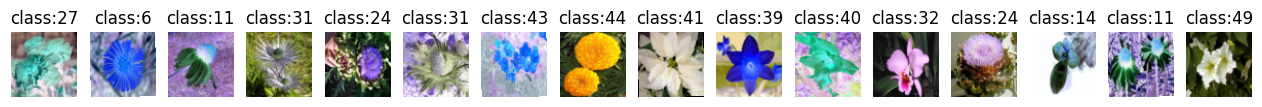

In [135]:
fig, axs = plt.subplots(1, sample_batch['images'].shape[0], figsize=(16, 4))
for i, (image, label) in enumerate(zip(sample_batch['images'], sample_batch['label'])):
    axs[i].imshow(image.permute(1, 2, 0).cpu().numpy() / 2 + 0.5)
    axs[i].set_axis_off()
    axs[i].set_title(f"class:{label}")
fig.show();


## Определение scheduler

В зависимости от алгоритма диффузии, который вы хотите использовать, способ зашумления изображений немного отличается. Вот почему 🤗 Diffusers содержит различные классы планировщика, каждый из которых определяет этапы диффузии, специфичные для алгоритма. Здесь мы собираемся использовать `DDPMScheduler`, который соответствует алгоритму шумоподавления и обучения, предложенному в [Вероятностные модели диффузии шумоподавления] (https://arxiv.org/abs/2006.11239).

In [90]:
from diffusers import  DDPMScheduler, DDIMScheduler, EulerDiscreteScheduler

#noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

#repo_id = BASE_PATH + 'flowers-512'
#noise_scheduler = EulerDiscreteScheduler.from_pretrained(repo_id, subfolder="scheduler")

noise_scheduler = DDIMScheduler.from_config("CompVis/ldm-celebahq-256", subfolder="scheduler")

The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


Давайте посмотрим, как работает этот планировщик шума: он берет батч изображений из обучающего набора (здесь мы будем повторно использовать пакет одного изображения в форме `sample_image`), батч случайного шума той же формы и временные шаги для каждого изображения. (что соответствует количеству раз, которое мы хотим применить к каждому изображению):

label tensor(38)


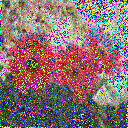

In [28]:
#import torch
from PIL import Image
sample = next(dataiter)
sample_image = sample['images'][0].unsqueeze(0)
sample_label = sample['label'][0]

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])

noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
print('label', sample_label)
Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

В алгоритме DDPM цель обучения модели состоит в том, чтобы иметь возможность предсказать шум, который мы использовали в `noise_scheduler.add_noise`, поэтому потери на этом этапе будут следующими:

In [29]:
import torch.nn.functional as F

noise_pred = cond_model(x = noisy_image,
                        t =  timesteps,
                        class_labels = sample_label[None])#.sample
loss = F.mse_loss(noise_pred, noise)
loss

tensor(1.1508, grad_fn=<MseLossBackward0>)

In [30]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [31]:
#cond_model = cond_model.to(DEVICE)
noise_pred = cond_model(x = noise_scheduler.add_noise(sample_image, noise, torch.LongTensor([50, 33])),
                        t =  torch.LongTensor([50, 33]),
                        class_labels = sample['label'][:2])

In [32]:
sample_label[None]

tensor([38])

In [33]:
noisy_image.shape, timesteps.shape, sample_label[None].shape


(torch.Size([1, 3, 128, 128]), torch.Size([1]), torch.Size([1]))

In [34]:
noise_pred.shape, noise.shape

(torch.Size([2, 3, 128, 128]), torch.Size([1, 3, 128, 128]))

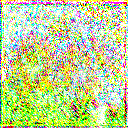

In [35]:
from PIL import Image, ImageDraw
def decode_latents(latents):
    images = 1 / 0.18215 * latents
    #print(latents.shape)
    #print(images.shape)
    images = (images / 2 + 0.5).clamp(0, 1)
    #print(images.shape)
    images = images.detach().cpu().permute(0, 2, 3, 1).numpy()
    #print(images.shape)
    images = (images * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

decode_images = decode_latents(noise_pred)
decode_images[0]

# Accelerator

In [36]:
from accelerate import Accelerator

In [37]:
accelerator = Accelerator()#fp16=True)


## Настройка обучения

У нас есть все необходимое для обучения нашей модели! Воспользуемся стандартным оптимизатором AdamW:

In [136]:
optimizer = torch.optim.AdamW(cond_model.parameters(), lr=config.learning_rate)
train_dataloader, cond_model, optimizer = accelerator.prepare(train_dataloader, cond_model, optimizer)

In [137]:
DEVICE = accelerator.device
DEVICE

device(type='cuda')

И косинусный scheduler:

In [40]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

## Custome_pipe

In [94]:
from tqdm.auto import tqdm
def cust_pipe(unet, seed, eval_batch_size, scheduler):
  # generate gaussian noise to be decoded
  generator =torch.manual_seed(seed)
  batch_size = eval_batch_size #config.eval_batch_size

  noise = torch.randn(
      (batch_size, 3, 128, 128),
      generator=generator).to(DEVICE)

  # set inference steps for DDIM
  noise_scheduler.set_timesteps(num_inference_steps=200)

  image = noise
  for t in tqdm(noise_scheduler.timesteps):
      # predict noise residual of previous image
      with torch.no_grad():
         labels = torch.tensor(np.random.choice(list(ALL_LABELS), batch_size)).to(DEVICE)
         #print(t)
         #print(image.shape, t.shape, label.shape)
         residual = unet(image, t, labels)#["sample"]



      # compute previous image x_t according to DDIM formula
      prev_image = noise_scheduler.step(residual, t, image)["prev_sample"]

      # x_t-1 -> x_t
      image = prev_image

  # decode image with vae
  pil_images = decode_latents(image)
  return pil_images, labels.cpu().numpy()

  0%|          | 0/200 [00:00<?, ?it/s]

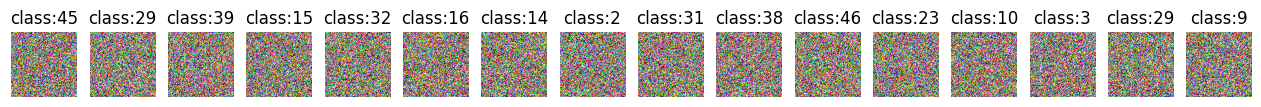

In [95]:
pil_images, labels = cust_pipe(cond_model, config.seed, config.eval_batch_size, noise_scheduler)

fig, axs = plt.subplots(1, len(pil_images), figsize=(16, 4))
for i, (image, label) in enumerate(zip(pil_images, labels)):
    axs[i].imshow(image)
    axs[i].set_axis_off()
    axs[i].set_title(f"class:{label}")
fig.show();

И косинусный scheduler:

In [97]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

Чтобы оценить нашу модель, мы используем DDPMPipeline, который представляет собой простой способ выполнения сквозного вывода (более подробную информацию см. в этом блокноте [ссылка TODO]). Мы будем использовать этот конвейер для создания пакета образцов изображений и сохранения его в виде сетки на диск.

In [104]:
from diffusers import DDPMPipeline #LDMSuperResolutionPipeline,
import os
import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid


def evaluate(config, epoch, pil_images, labels): #pipeline):
    # Сэмплируем несколько изображений из случайного шума (это обратный процесс диффузии).
    # Выход пайплайна по умолчанию - `List[PIL.Image]`
    #images = pipeline(
        #batch_size = config.eval_batch_size,
        #generator=torch.manual_seed(config.seed),
    #).images

    # Делаем сетку из изображений
    image_grid = plot_listimages(pil_images, labels, save=True)
    #image_grid = make_grid(pil_images,
                           #rows=2,
                           #cols=2)

    # Сохраняем изображения
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [152]:
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path


def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    global_step = 0


    # Теперь обучаем модель
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader))
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images'].to(DEVICE)
            labels = batch['label'].to(DEVICE)


            # Сэмплируем шум чтобы добавить к изображениям
            noise = torch.randn(clean_images.shape).to(DEVICE)
            bs = clean_images.shape[0]

            # Сэмплируем временной шаг для каждого изображений
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=DEVICE).long()
            #print(timesteps)
            # Добавляем шум к чистым изображениям в соответствии с величиной шума на каждом временном шаге
            # (это процесс прямой диффузии)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            #print(clean_images.shape, labels.shape, noisy_images.shape,  noise.shape)
            # Предсказываем остаток шума
            noise_pred = model(noisy_images, timesteps, labels)#[0]
            loss = F.mse_loss(noise_pred, noise)
            loss.backward()

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            global_step += 1

        # После каждой эпохи вы при желании можете сэмплировать несколько изображений с помощью функции evaluate() и сохранить модель.
        #pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)


        if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
            pil_images, labels = cust_pipe(model, config.seed, config.eval_batch_size, noise_scheduler)
            evaluate(config, epoch, pil_images, labels)

        #if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            #pipeline.save_pretrained(config.output_dir)

В итоге мы можем сгруппировать все вместе и написать нашу обучающую функцию. Это просто завершает этап обучения, который мы видели в предыдущем разделе.

## Давайте обучать!

Давайте запустим обучение. Перед запуском перезагрузите среду, так как у вас не хватит памяти на GPU


In [ ]:
train_loop(config, cond_model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

  0%|          | 0/200 [00:00<?, ?it/s]

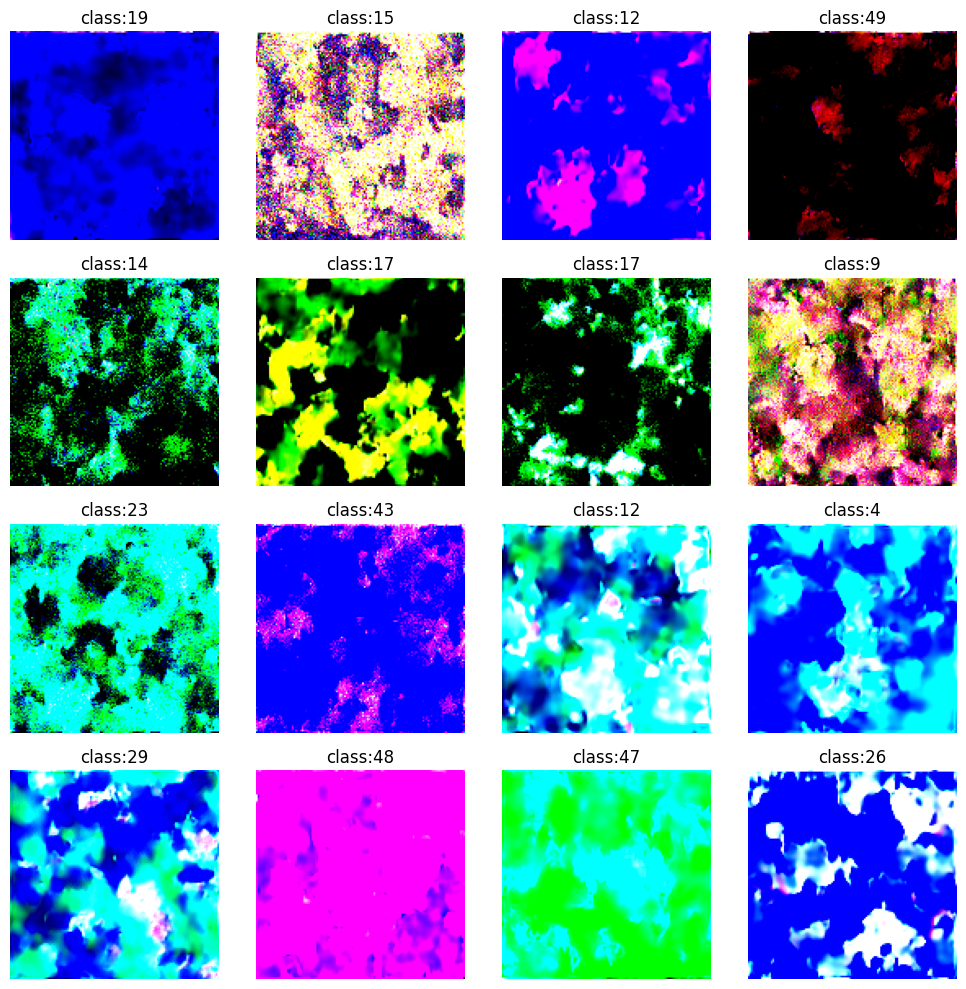

In [ ]:
pil_images, labels = cust_pipe(cond_model, config.seed, config.eval_batch_size, noise_scheduler)
evaluate(config, 0, pil_images, labels)

Давайте посмотрим на окончательную сетку изображения, созданную обученной моделью диффузии:

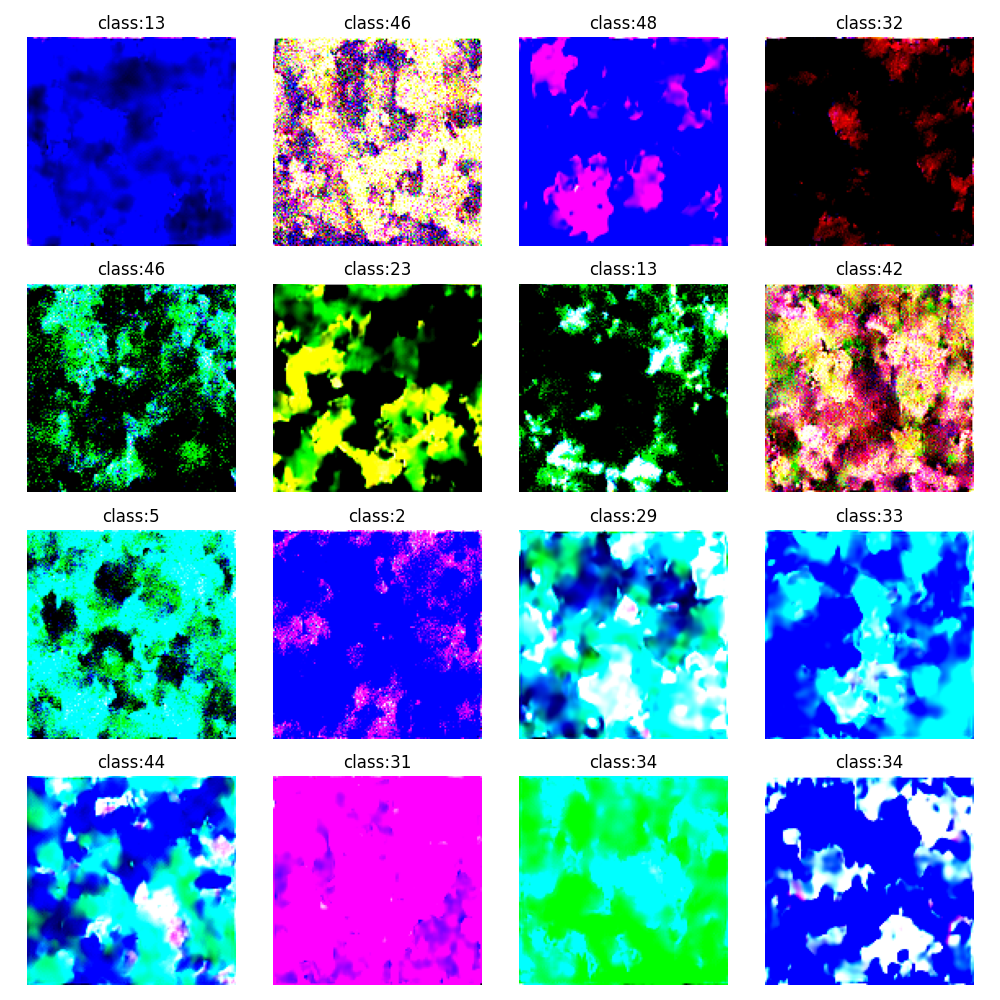

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])